# Generic compartments model - summary
This is a summary of how to use the model and of the results we get.

In [1]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

import gc_model as gc # The model itself
import hic_analysis as hic # Useful analysis functions
import visualize # Visualizations we'll use later on. Can also be run as a script.

There are two main things we can do with that model: Fit it to existing data and regenerate an interaction matrix using  model parameters.

## Overview of the generic model
The generic model assumes that two bins interact as a result of two causes:
* They are physically close
* They're in states (or compartments) that interact with each other. The strength of interaction isn't the same for all states - for example, bins that are both in state 1 can interact with each other more often compared to bins that are divided between state 3 and 4.

The probability for interaction of any two bins i, j, assuming each bin can be in one of 3 states A, B, C is then:

$$P(i, j) = ||i-j|| ^\alpha ( \lambda^{A}_i\lambda^{A}_jw_{AA} + \lambda^{A}_i\lambda^{B}_jw_{AB} + ... + \lambda^{C}_i\lambda^{C}_jw_{CC}) $$

Or in matrix form:

$$ P(i, j) = ||i-j||^\alpha (\Lambda w \Lambda^T)_{(i,j)} $$

Where $\Lambda$ is a BINSxSTATES matrix of bin-to-state assignment probabilities, w is a STATESxSTATES symmetric matrix of state-state interactions weights and $\alpha$ is the distance-decay exponent.

The model takes as a parameter the number of state there is, and returns $\Lambda$, $w$ and $\alpha$.

## Fitting the model

In [2]:
# To load data from npy file:
input_data = np.load('Rao2015_chr20_20000.npy')
# Alternative using mcool:
#input_data = hic.get_matrix_from_coolfile('Rao2015.mcool', 20000, 'chr20')

# To run the model as a function:
#probabilities, weights, alpha = gc.fit(input_data, number_of_states=3)
# To load results from gc_model_main.py
probabilities = np.load('./output/lambda_probabilities_3states.npy')
weights = np.load('./output/model_state_weights_3states.npy')
alpha = np.load('./output/model_distance_decay_power_value_3states.npy')

## Reconstructing the interaction matrix

In [3]:
reconstructed_matrix = gc.generate_interactions_matrix(probabilities, weights, alpha)

## Analysing results

Analysing the results makes heavy use of the hic_analysis library. It contains many useful functions.

### Interactions

In order to compare the data and the reconstruction, we first need to make sure the input matrix is in the right format (no main diag, normalized sum, etc)

In [4]:
original_mat = hic.preprocess(input_data)

Now we can plot the results. To get meaningful images, we'll first normalize by distance and then take a log. Because log must take non-zero values, we'll convert zeros to NaN using a hic_analysis function.

In [5]:
original_normalized = hic.normalize_distance(original_mat)
recons_normalized = hic.normalize_distance(reconstructed_matrix)

/Users/hkariti/repo/technion/Compartments/hic_analysis.py:79: RuntimeWarning: Mean of empty slice
  diag_mean = np.nanmean(diag)


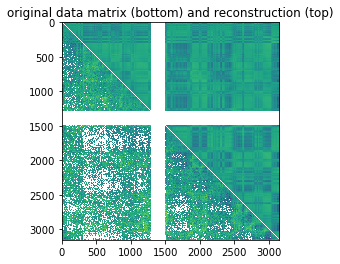

In [6]:
plt.figure()
plt.title('original data matrix (bottom) and reconstruction (top)')
merged = hic.merge_by_diagonal(original_normalized, recons_normalized)
plt.imshow(hic.safe_log(merged)) # shorthand for np.log(hic.zeros_to_nan(x))
plt.show()

### Correlation with original matrix

In [7]:
stats.pearsonr(hic.remove_nan(recons_normalized), hic.remove_nan(original_normalized))

(0.43053521625770524, 0.0)

With more states, correlation increases. Example from more runs:

|Number of states| Correlation |
|----------------|-------------|
|2 | 0.44058|
|3 | 0.43054|
|4 | 0.49943|
|5 | 0.51910|

We can also calculate the likelihood:

In [8]:
likelihood = np.nansum(hic.zeros_to_nan(original_normalized) * np.log(hic.zeros_to_nan(recons_normalized)))
optimal_likelihood = np.nansum(hic.zeros_to_nan(original_normalized) * np.log(hic.zeros_to_nan(original_normalized)))
print("Achieved log-likelihood:", likelihood)
print("Optimal log-likelihood:", optimal_likelihood)

Achieved log-likelihood: -30.393340958283872
Optimal log-likelihood: -29.7575629406197


### State probabilities

We'll plot the probability for each state, and compare with a 2-state model:

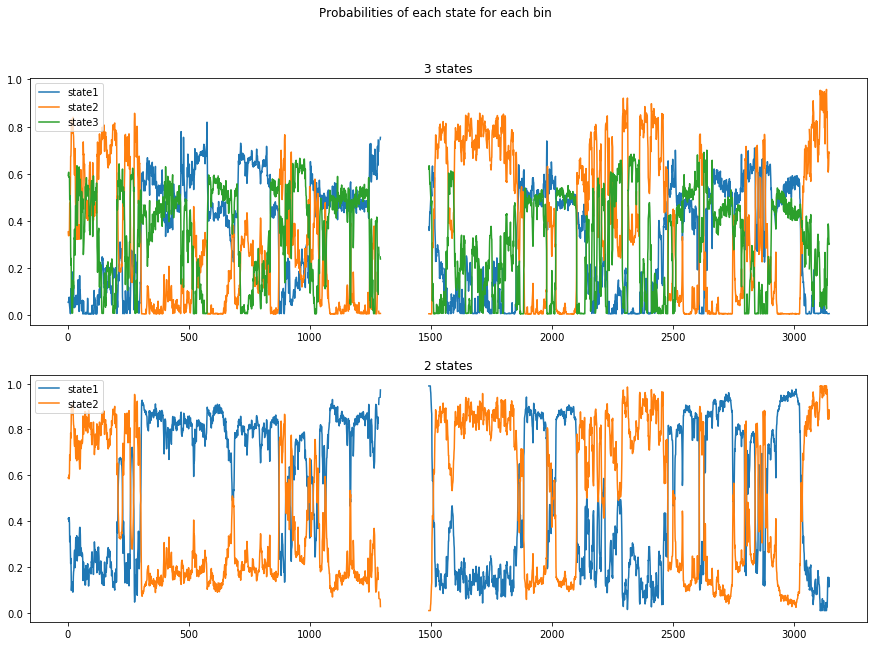

In [9]:
probabilities_2states = np.load('./output/lambda_probabilities_2states.npy')
f = plt.figure(figsize=(15, 10))
f.suptitle("Probabilities of each state for each bin")
ax3 = f.add_subplot(2, 1, 1)
ax3.plot(probabilities)
ax3.set_title("3 states")
ax3.legend(['state1', 'state2', 'state3'], loc='upper left')

ax2 = f.add_subplot(2, 1, 2)
ax2.plot(probabilities_2states)
ax2.set_title("2 states")
ax2.legend(['state1', 'state2'], loc='upper left')

plt.show()

We can see that the state2 in both graphs seems more or less the same, but state1 from the 2-state model has split into state1 and state3.

### Weights matrix

The resulting state-state interaction weights:

In [10]:
weights

array([[0.34550207, 0.00364696, 0.00364696],
       [0.00364696, 0.27251748, 0.00364696],
       [0.00364696, 0.00364696, 0.36009866]])

We can see that altough the model is not limited to a specific matrix form, the result is very close to a diagonal matrix. On top of that, the values outside of the diagonal are all equal. I don't have an explanation for that, but it doesn't seem to be a limitation of the model. Fitting the model to a matrix generated using a random weights matrix produces matrices with non-negligible values outside the diagonal.

## Comparison with histone modifications

A direction I didn't have time to look into is comparing the state probability vector with histone modifications. For visualizing these modifications, we can use the visualize library after setting matplotlib to interactive mode. Each line in the graph can be removed for improved readability by clicking its legend picker.

In [11]:
%matplotlib qt
visualize.histones_figure('./histone_modifications/')

We can show in addition the probabilities data and interaction matrix, and connect their x-axis to the histones charts.

In [12]:
visualize.all_figures(input_data, probabilities, alpha, weights, './histone_modifications')